In [42]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

### Quadratic equation graph

In [22]:
class QEstate(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str

In [11]:
def show_equation(state: QEstate) -> QEstate:
    a = state["a"]
    b = state["b"]
    c = state["c"]

    state['equation'] = f'{a}x^2 + {b}x + c'

    return state

In [12]:
def calc_d(state: QEstate) -> QEstate:
    a = state["a"]
    b = state["b"]
    c = state["c"]

    state['discriminant'] = b**2 - (4*a*c)

    return state

In [23]:
def real_roots(state: QEstate) -> QEstate:
    a = state["a"]
    b = state["b"]
    c = state["c"]
    d = state["discriminant"]

    root1 = (- b - d**2) / (2*a)
    root2 = (- b + d**2) / (2*a)

    state['result'] = f'The two real roots are {root1} and {root2}'

    return state

In [24]:
def repeated_roots(state: QEstate) -> QEstate:
    a = state["a"]
    b = state["b"]
    c = state["c"]
    d = state["discriminant"]

    root = (- b) / (2*a)

    state['result'] = f'Both the roots are same: {root}'

    return state

In [25]:
def no_real_roots(state: QEstate) -> QEstate:

    state['result'] = f'The equation has no real roots'

    return state

In [36]:
def router(state: QEstate) -> Literal["real roots", "repeated roots", "no real roots"]:
    d = state['discriminant']

    if d > 0: 
        return "real roots"

    elif d == 0: 
        return "repeated roots"

    elif d < 0:
        return "no real roots"

In [37]:
graph = StateGraph(QEstate)


In [38]:
graph.add_node("show equation", show_equation)
graph.add_node("calculate discriminant", calc_d)
graph.add_node("real roots", real_roots)
graph.add_node("repeated roots", repeated_roots)
graph.add_node("no real roots", no_real_roots)

graph.add_edge(START, "show equation")
graph.add_edge("show equation", "calculate discriminant")
graph.add_conditional_edges("calculate discriminant", router)
graph.add_edge("real roots", END)
graph.add_edge("repeated roots", END)
graph.add_edge("no real roots", END)

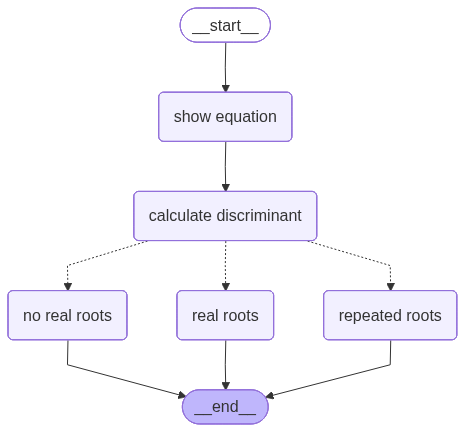

In [39]:
workflow = graph.compile()
workflow

In [41]:
initial_state = {'a': 3, 'b': -7, 'c': 2}
final_state = workflow.invoke(initial_state)
final_state

{'a': 3,
 'b': -7,
 'c': 2,
 'equation': '3x^2 + -7x + c',
 'discriminant': 25,
 'result': 'The two real roots are -103.0 and 105.33333333333333'}

### LLM conditional graph

In [49]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [50]:
load_dotenv()

True

In [91]:
class review_eval(BaseModel):
    sentiment: Literal["positive", "negative", "neutral"] = Field(description='sentiment of the review')
    # score: int = Field(description='a score out of 10')

In [92]:
llm = ChatOpenAI(model='gpt-4o-mini')
struc_llm = llm.with_structured_output(review_eval)

In [93]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "neutral"]
    diagnosis: dict
    response: str

In [94]:
def eval_sentiment(state: ReviewState) -> ReviewState:
    prompt = f'Evaluate the sentiment of the following customer review: \n {state['review']}'
    state['sentiment'] = struc_llm.invoke(prompt).sentiment
    return state

In [100]:
prompt = f'Evaluate the sentiment of the following customer review: \n "I love this"'
struc_llm.invoke(prompt)

review_eval(sentiment='positive')

In [95]:
graph = StateGraph(ReviewState)

In [96]:
graph.add_node("evaluate sentiment", eval_sentiment)
graph.add_edge(START, "evaluate sentiment")
graph.add_edge("evaluate sentiment", END)

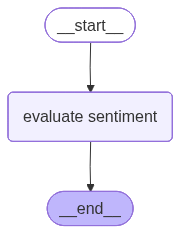

In [97]:
workflow = graph.compile()
workflow

In [98]:
intial_state = {'review': 'I did not like this product at all'}
workflow.invoke(initial_state)

KeyError: 'review'